# Plaque spot segmentation with SAM 3


Use the SAM 3 image predictor to segment plaque spots with a text prompt. <br>
The default prompt is **spot**; change it if you want to try other words.

⚠️ Before using SAM 3, please request access to the checkpoints on the SAM 3 Hugging Face repo.
[https://huggingface.co/facebook/sam3](https://huggingface.co/facebook/sam3)
Once accepted, you need to be authenticated to download the checkpoints. You can do this by running the following steps in the command terminal of your device.<br> (e.g. ```hf auth login``` inside your terminal after generating an access token in your huggingface profile settings.) <br>The Access Token only needs access to the sam3 repo.

**Installation:**
**Prerequisites**<br>
- [Python 3.12 or higher](https://www.python.org/downloads/)
- [PyTorch 2.7 or higher](https://pytorch.org/get-started/locally/): ```pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128``` 
- CUDA-compatible GPU with CUDA 12.6 or higher
- [CUDA Toolkit installed on your local device](https://developer.nvidia.com/cuda-downloads)
- [Anaconda](https://www.anaconda.com/download/) (Miniconda is sufficient)

This jupyter notebook will need to be placed inside an existing folder once you will have cloned the sam3 repo.

**Create a new Conda environment**:<br>
Open Anaconda Prompt
```conda create -n sam3 python=3.12```
```conda deactivate```
```conda activate sam3```

**Clone the repository and install the package**:<br>
```git clone https://github.com/facebookresearch/sam3.git``` <br>
```cd sam3``` <br>
```pip install -e``` . <br>
Install additional dependencies for notebooks:
```pip install -e ".[notebooks]"``` <br>

**Move this Jupyter notebook** <br>```sam3_plaque_spot_segmentation.ipynb``` inside the ```sam3\examples``` folder<br>
**Still in your Anaconda Prompt Terminal, open the notebook** <br>
```jupyter notebook examples/sam3_image_predictor_example.ipynb``` <br>

In [1]:
import sys, subprocess, sys

In [2]:
import torch
print(torch.__version__)

2.9.1+cu128


In [3]:
torch.cuda.is_available()

True

In [4]:
import torch

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

has_cuda = torch.cuda.is_available()
device = "cuda" if has_cuda else "cpu"
autocast_ctx = torch.autocast("cuda", dtype=torch.bfloat16) if device == "cuda" else nullcontext()
print(f"Using device: {device}")


Using device: cuda


In [5]:
from contextlib import nullcontext
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

import sam3
from sam3 import build_sam3_image_model
from sam3.model.sam3_image_processor import Sam3Processor
from sam3.visualization_utils import plot_results


C:\Users\Stat\anaconda3\envs\sam3\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find cuobjdump.exe
  warnings.warn(f"Failed to find {binary}")
C:\Users\Stat\anaconda3\envs\sam3\Lib\site-packages\triton\knobs.py:212: UserWarning: Failed to find nvdisasm.exe
  warnings.warn(f"Failed to find {binary}")


In [6]:
sam3_root = Path(sam3.__file__).resolve().parent.parent
plaques_dir = sam3_root / "assets" / "images" / "plaques"

image_paths = sorted([p for p in plaques_dir.iterdir() if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}])
if not image_paths:
    raise FileNotFoundError(f"No plaque images found at {plaques_dir}")

print("Found plaque images:")
for idx, path in enumerate(image_paths):
    print(f"[{idx}] {path.name}")

bpe_path = sam3_root / "assets" / "bpe_simple_vocab_16e6.txt.gz"
model = build_sam3_image_model(bpe_path=bpe_path)
model = model.to(device)
processor = Sam3Processor(model, confidence_threshold=0.5)


Found plaque images:
[0] plate1uncounted.png
[1] plate2uncounted.png


Pick a plaque image and adjust the text prompt if needed.


In [7]:
spot_prompt = "spot"  # change to try other prompts
selected_index = 0       # change the index printed above
selected_image = image_paths[selected_index]
print(f"Selected: {selected_image.name}")


Selected: plate1uncounted.png


Prompt: spot | Image: plate1uncounted.png
found 27 object(s)


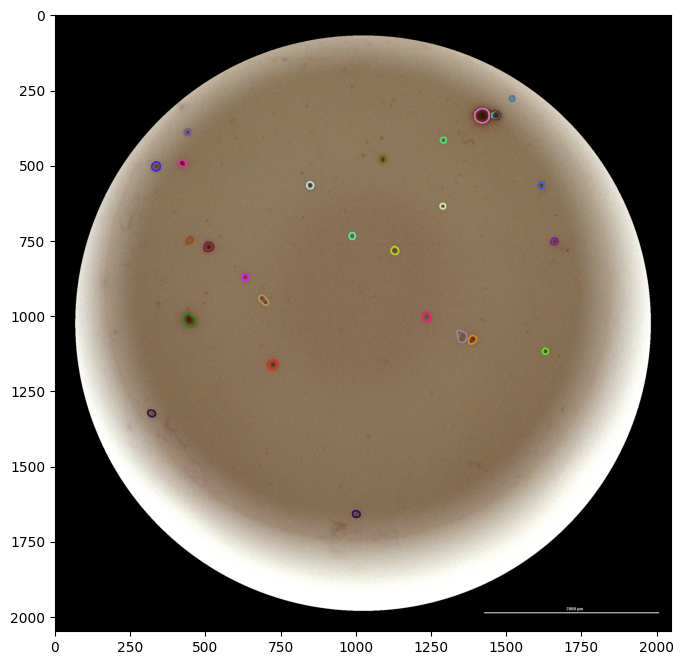

In [8]:
def segment_image_with_prompt(image_path: Path, prompt: str):
    img = Image.open(image_path).convert("RGB")
    with autocast_ctx:
        state = processor.set_image(img)
        processor.reset_all_prompts(state)
        state = processor.set_text_prompt(state=state, prompt=prompt)
    print(f"Prompt: {prompt} | Image: {image_path.name}")
    plot_results(img, state)

segment_image_with_prompt(selected_image, spot_prompt)


Run the same prompt across all plaque images (optional).


Prompt: spot | Image: plate1uncounted.png
found 27 object(s)
Prompt: spot | Image: plate2uncounted.png
found 31 object(s)


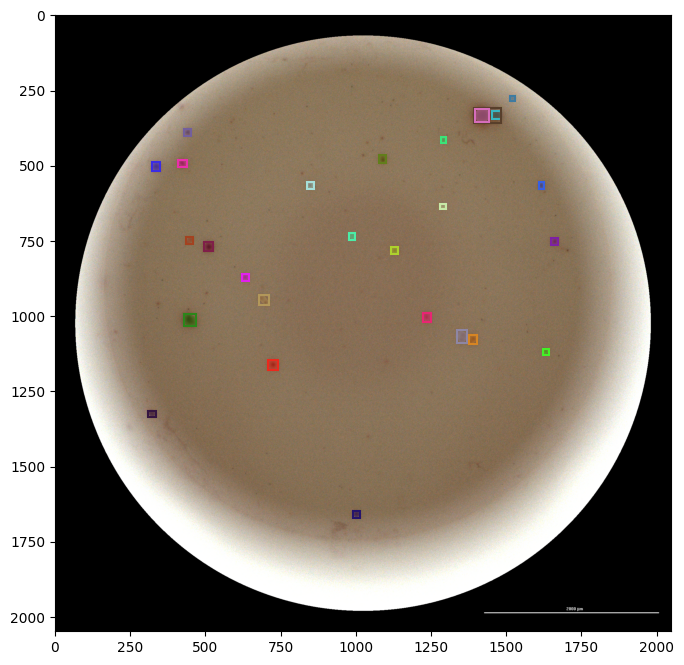

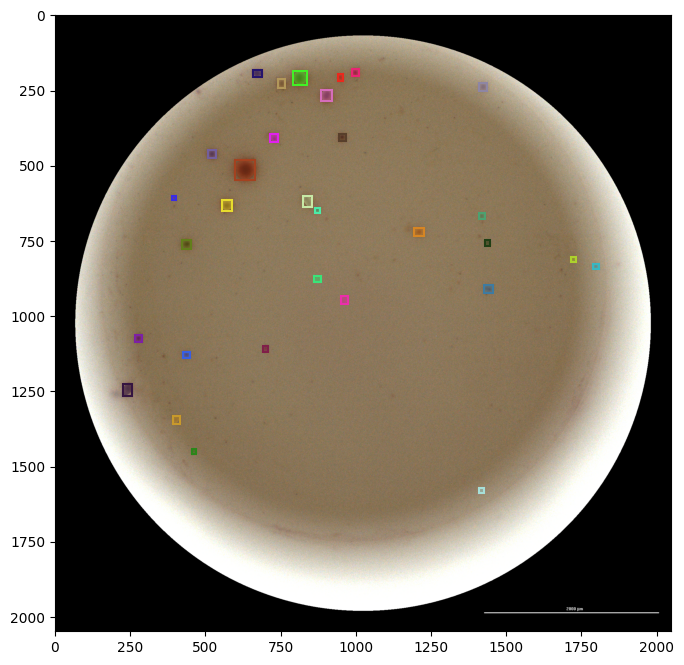

In [14]:
for path in image_paths:
    segment_image_with_prompt(path, spot_prompt)